In [3]:
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline 
import numpy as np
database = "chinook.db"
def run_query(q):
    with sqlite3.connect(database) as conn:
        return pd.read_sql_query(q,conn)
def run_command(c):
    with sqlite3.connect(database) as conn:
        conn.isolation_level=None
        conn.execute(c)
def show_tables():
    query='''SELECT 
                name,type 
            from sqlite_master 
            where type in ("table","view");'''
    return run_query(query) 
show_tables()

,name,type
0,album,table
1,artist,table
2,customer,table
3,employee,table
4,genre,table
5,invoice,table
6,invoice_line,table
7,media_type,table
8,playlist,table
9,playlist_track,table


In [11]:
tracks_sold_usa='''
WITH tracks_sold_usa as 
(
    SELECT il.* from invoice_line il 
    INNER JOIN invoice i on i.invoice_id = il.invoice_id
    INNER JOIN customer c on c.customer_id=i.customer_id
    where c.country = "USA"
)

SELECT 
    g.name GENRE,
    COUNT(tsu.invoice_line_id) tracks_sold,
    cast(COUNT(tsu.invoice_line_id) as float) / (
        select count(*) from tracks_sold_usa 
    ) Percentage_of_Tracks_Sold
FROM tracks_sold_usa tsu
INNER JOIN track t on t.track_id = tsu.track_id
INNER JOIN genre g on g.genre_id = t.genre_id
GROUP BY 1
ORDER BY 2 DESC
LIMIT 10;'''


run_query(tracks_sold_usa)

,GENRE,tracks_sold,Percentage_of_Tracks_Sold
0,Rock,561,0.533777
1,Alternative & Punk,130,0.123692
2,Metal,124,0.117983
3,R&B/Soul,53,0.050428
4,Blues,36,0.034253
5,Alternative,35,0.033302
6,Latin,22,0.020932
7,Pop,22,0.020932
8,Hip Hop/Rap,20,0.019029
9,Jazz,14,0.013321


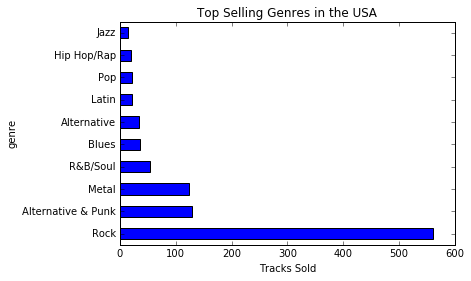

In [17]:
genre_sales_usa = run_query(albums_to_purchase)
genre_sales_usa.set_index("genre",inplace=True,drop=True)
genre_sales_usa["tracks_sold"].plot.barh(
title="Top Selling Genres in the USA"
)
plt.xlabel("Tracks Sold")
    

In [21]:
agent_sales = """
WITH sales_rep as (
    SELECT i.customer_id,c.support_rep_id,SUM(i.total) total
    FROM invoice i 
    INNER JOIN customer c ON i.customer_id = c.customer_id
    GROUP BY 1,2
)
SELECT e.first_name || " " || e.last_name NAME,e.hire_date HIRED,
SUM(sr.total)
FROM sales_rep sr 
INNER JOIN employee e ON e.employee_id = sr.support_rep_id
GROUP BY 1;
"""
run_query(agent_sales)

,NAME,HIRED,SUM(sr.total)
0,Jane Peacock,2017-04-01 00:00:00,1731.51
1,Margaret Park,2017-05-03 00:00:00,1584.00
2,Steve Johnson,2017-10-17 00:00:00,1393.92


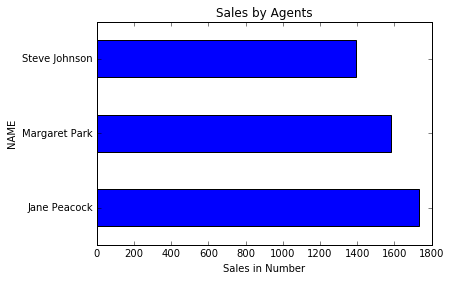

In [25]:
sales_frame = run_query(agent_sales)
sales_frame.set_index("NAME",inplace=True,drop=True)
sales_frame["SUM(sr.total)"].plot.barh(
    title="Sales by Agents"
)
plt.xlabel("Sales in Number")

In [37]:
country_wise_sales = '''
WITH country_present AS
    (
     SELECT
       CASE
           WHEN (
                 SELECT count(*)
                 FROM customer
                 where country = c.country
                ) = 1 THEN "Other"
           ELSE c.country
       END AS country,
       c.customer_id,
       il.*
     FROM invoice_line il
     INNER JOIN invoice i ON i.invoice_id = il.invoice_id
     INNER JOIN customer c ON c.customer_id = i.customer_id
    )

SELECT
    country,
    customers,
    total_sales
FROM
    (
    SELECT
        country,
        count(distinct customer_id) customers,
        SUM(unit_price) total_sales,
        CASE
            WHEN country = "Other" THEN 1
            ELSE 0
        END AS sort
    FROM country_present
    GROUP BY country
    ORDER BY sort ASC, total_sales DESC
    );
 '''   
run_query(country_wise_sales)

,country,customers,total_sales
0,USA,13,1040.49
1,Canada,8,535.59
2,Brazil,5,427.68
3,France,5,389.07
4,Germany,4,334.62
5,Czech Republic,2,273.24
6,United Kingdom,3,245.52
7,Portugal,2,185.13
8,India,2,183.15
9,Other,15,1094.94


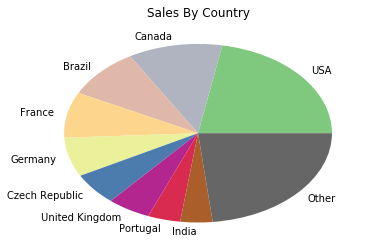

In [44]:
sales_world_wide = run_query(country_wise_sales)
sales_world_wide.set_index("country",inplace = True , drop = True)
total_sales_pie = sales_world_wide["total_sales"]
total_sales_pie.plot.pie(
    title = "Sales By Country",
    colormap = plt.cm.Accent,
    wedgeprops={'linewidth':0}
)
plt.ylabel("")